# Importing Libraries and Data

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F


In [123]:
points = np.array([np.random.uniform(-2,2,750), np.random.uniform(-2,2,750)]).reshape((750,2))
points.shape

(750, 2)

In [124]:
xor = pd.DataFrame(points)
xor.columns = ["x1", "x2"]
xor["label"] = None
for i, row in xor.iterrows():
    if (row["x1"]>=0 and row["x2"]>=0) or (row["x1"]<0 and row["x2"]<0):
        xor.at[i, "label"] = 0
    else:
        xor.at[i, "label"] = 1
xor

,x1,x2,label
0,-1.306549,-0.149667,0
1,1.307505,1.691851,0
2,-0.060324,-1.830595,0
3,-1.128278,-1.745589,0
4,1.450290,-0.052167,1
...,...,...,...
745,1.494807,1.888894,0
746,0.887762,0.735106,0
747,-0.381800,0.681801,1
748,1.912484,-1.403296,1


In [125]:
xor.label.value_counts()

label
0    383
1    367
Name: count, dtype: int64

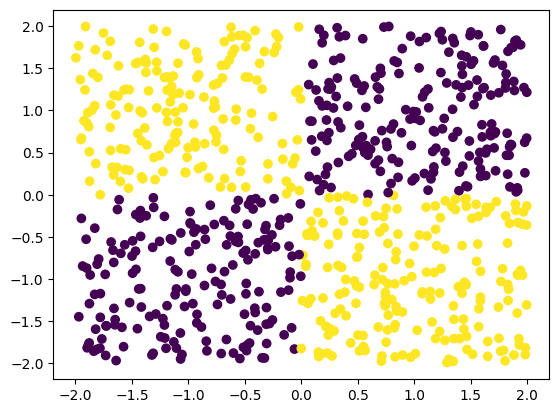

In [126]:
plt.scatter(x=xor["x1"].values, y=xor["x2"].values, c=xor.label);

In [127]:
X = xor.drop(columns="label")
y = xor["label"].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, stratify=y, random_state=1)

In [128]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((637, 2), (113, 2), (637,), (113,))

In [129]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=1)

In [130]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((573, 2), (64, 2), (573,), (64,))

In [131]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features, hidden_units=16):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_features)
        )
    def forward(self, x):
        return self.stack(x)

In [132]:
mlp = MLP(2, 2)
print(mlp)

MLP(
  (stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [133]:
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=0.1)

In [134]:
# X_train = torch.from_numpy(X_train.values).to(dtype=torch.float32)
# X_val = torch.from_numpy(X_val.values).to(dtype=torch.float32)
# y_train = torch.from_numpy(y_train.astype(int).values).to(dtype=torch.int64)
# y_val = torch.from_numpy(y_val.astype(int).values).to(dtype=torch.int64)
# X_test = torch.from_numpy(X_test.values).to(dtype=torch.int)
# y_test = torch.from_numpy(y_test.astype(int).values).to(dtype=torch.int64)

In [135]:
class xorDataset(Dataset):
    def __init__(self, X, y):
        self.features = torch.tensor(X.values, dtype=torch.float32)
        self.labels = torch.tensor(y.astype(int), dtype=torch.int64)
    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]
        return x,y
    def __len__(self):
        return self.labels.shape[0]

train_ds = xorDataset(X_train, y_train)
val_ds = xorDataset(X_val, y_val)
test_ds = xorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

def accuracy_fn(model, dataloader):
    correct = 0
    total = 0
    model = model.eval()
    for features, labels in dataloader:
        with torch.inference_mode():
            logits = model(features)
        y_pred = torch.argmax(logits, dim=1)
        compare = labels == y_pred
        correct += torch.sum(compare)
        total += len(compare)
    return correct/total

In [150]:
epochs = 20

mlp = MLP(2, 2)
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=0.02)

for epoch in range(epochs):

    mlp = mlp.train()
    for batch_idx, (features, labels) in enumerate(train_loader):
        logits = mlp(features)

        train_loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()

        train_loss.backward()
        optimizer.step()

    test_acc = accuracy_fn(mlp, val_loader)
    print(f"Epoch: {epoch+1}/{epochs} | Train loss: {train_loss:.3f} |  Val acc: {test_acc:.3f}")

Epoch: 1/20 | Train loss: 0.186 |  Val acc: 0.938
Epoch: 2/20 | Train loss: 0.068 |  Val acc: 0.984
Epoch: 3/20 | Train loss: 0.021 |  Val acc: 0.984
Epoch: 4/20 | Train loss: 0.124 |  Val acc: 0.984
Epoch: 5/20 | Train loss: 0.065 |  Val acc: 0.953
Epoch: 6/20 | Train loss: 0.021 |  Val acc: 0.969
Epoch: 7/20 | Train loss: 0.017 |  Val acc: 0.969
Epoch: 8/20 | Train loss: 0.038 |  Val acc: 0.969
Epoch: 9/20 | Train loss: 0.122 |  Val acc: 0.969
Epoch: 10/20 | Train loss: 0.017 |  Val acc: 0.969
Epoch: 11/20 | Train loss: 0.005 |  Val acc: 0.969
Epoch: 12/20 | Train loss: 0.042 |  Val acc: 0.984
Epoch: 13/20 | Train loss: 0.143 |  Val acc: 0.984
Epoch: 14/20 | Train loss: 0.138 |  Val acc: 0.969
Epoch: 15/20 | Train loss: 0.111 |  Val acc: 0.953
Epoch: 16/20 | Train loss: 0.056 |  Val acc: 0.953
Epoch: 17/20 | Train loss: 0.076 |  Val acc: 0.969
Epoch: 18/20 | Train loss: 0.077 |  Val acc: 0.969
Epoch: 19/20 | Train loss: 0.003 |  Val acc: 0.984
Epoch: 20/20 | Train loss: 0.004 |  Val 

In [151]:
print(f"Test accuracy: {accuracy_fn(mlp, test_loader):.3f}")

Test accuracy: 0.991


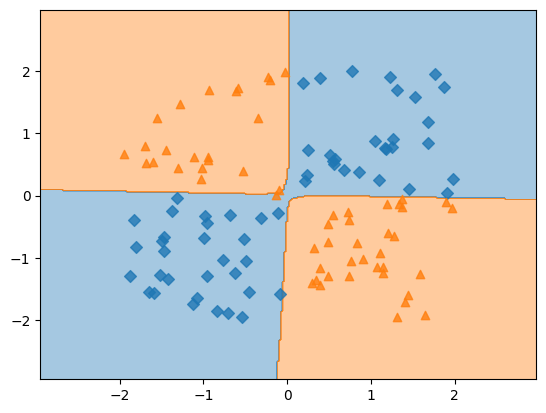

In [155]:
from matplotlib.colors import ListedColormap
import numpy as np


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('D', '^', 'x', 's', 'v')
    colors = ('C0', 'C1', 'C2', 'C3', 'C4')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    logits = classifier.forward(tensor)
    Z = np.argmax(logits.detach().numpy(), axis=1)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    #edgecolor='black',
                    marker=markers[idx],
                    label=cl)

plot_decision_regions(X_test.values, y_test, mlp)